In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
path1='/home/minhvu/Desktop/Py4DS/cuối kì/2020/dataset_du_doan_luu_luong_server/sample_submission.csv'
path2='/home/minhvu/Desktop/Py4DS/cuối kì/2020/dataset_du_doan_luu_luong_server/test_id.csv'
path3='/home/minhvu/Desktop/Py4DS/cuối kì/2020/dataset_du_doan_luu_luong_server/train.csv'
submission=pd.read_csv(path1)
test_id=pd.read_csv(path2)
train=pd.read_csv(path3)

In [3]:
submission.head()

,id,label
0,0,0.00 0
1,1,0.00 0
2,2,0.00 0
3,3,0.00 0
4,4,0.00 0


In [4]:
submission.shape

(2226, 2)

In [5]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2226 entries, 0 to 2225
Data columns (total 2 columns):
id       2226 non-null int64
label    2226 non-null object
dtypes: int64(1), object(1)
memory usage: 34.9+ KB


In [6]:
test_id.head()

,id,UPDATE_TIME,ZONE_CODE,HOUR_ID
0,0,2019-03-10,ZONE01,0
1,1,2019-03-10,ZONE01,1
2,2,2019-03-10,ZONE01,2
3,3,2019-03-10,ZONE01,3
4,4,2019-03-10,ZONE01,4


In [7]:
test_id.shape

(2226, 4)

In [8]:
test_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2226 entries, 0 to 2225
Data columns (total 4 columns):
id             2226 non-null int64
UPDATE_TIME    2226 non-null object
ZONE_CODE      2226 non-null object
HOUR_ID        2226 non-null int64
dtypes: int64(2), object(2)
memory usage: 69.6+ KB


In [9]:
train.head()

,UPDATE_TIME,ZONE_CODE,HOUR_ID,BANDWIDTH_TOTAL,MAX_USER
0,2017-10-01,ZONE01,0,16096.710313,212415.0
1,2017-10-01,ZONE01,1,9374.207907,166362.0
2,2017-10-01,ZONE01,2,5606.225750,146370.0
3,2017-10-01,ZONE01,3,4155.654661,141270.0
4,2017-10-01,ZONE01,4,3253.978594,139689.0


In [10]:
train.shape

(35544, 5)

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35544 entries, 0 to 35543
Data columns (total 5 columns):
UPDATE_TIME        35544 non-null object
ZONE_CODE          35544 non-null object
HOUR_ID            35544 non-null int64
BANDWIDTH_TOTAL    35544 non-null float64
MAX_USER           35544 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.4+ MB


In [12]:
#Drop duplicates and set time index
train.drop_duplicates(inplace=True)
train['DATE_TIME'] = train['UPDATE_TIME'] + ' ' + (train['HOUR_ID'].astype(str)) + ':00:00'
train['DATE_TIME'] = pd.to_datetime(train['DATE_TIME'])
train.set_index('DATE_TIME',inplace=True)

In [13]:
## Define function and metrics
import datetime

def mean_absolute_percentage_error(a, b): 
    a = np.array(a)
    b = np.array(b)
    mask = a != 0
    return (np.abs(a - b)/a)[mask].mean()*100

def smape(a, b): 
    a = np.array(a)
    b = np.array(b)
    mask = a != 0
    return (np.abs(a - b)/(np.abs(a)+np.abs(b)))[mask].mean()*100
                         
def split_1(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

def split_2(sequence, n_steps):
    a = list(sequence)
    X,y = list(), list()
    for i in reversed(range(len(a))):
        if i == n_steps-1:
            break
        seq_y = a[i]
        seq_x = a[i-n_steps:i:24] + a[i-24:i] \
                +[np.mean(a[i-n_steps:i:24]),
                  np.min(a[i-n_steps:i:24]),
                  np.max(a[i-n_steps:i:24])]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

def generate_date_time_series(d):
    start = d[0]
    end = d[1]
    step = datetime.timedelta(hours=1)

    result = []

    while start < end:
        result.append(start.strftime('%Y-%m-%d %H:%M:%S'))
        start += step
    result.append(d[1])
    return result

# Model

In [14]:
from sklearn.linear_model import Ridge
Nlog=True

def model_1(TIMESERIAL):
    
    train,test = TIMESERIAL[:-24*31],TIMESERIAL[-24*31:]
    n_steps = 24*31
    X, y = split_1(TIMESERIAL,n_steps)
    X_train = X
    y_train = y
    
    model = Ridge()
    model.fit(X_train, y_train)
    pred = model.predict(X_train)
    if Nlog:
        y_train = np.exp(y_train)
        pred = np.exp(pred)
    print(smape(y_train,pred))
    
    bw_pred = []
    for i in range(24*31):
        seq = TIMESERIAL[-n_steps:]
        yhat = model.predict(np.array([seq]))
        TIMESERIAL = np.append(TIMESERIAL,yhat[0])
        bw_pred.append(yhat[0])
    if Nlog:
        bw_pred = np.exp(bw_pred)
        
    return bw_pred

def model_2(TIMESERIAL):
    
    train,test = TIMESERIAL[:-24*31],TIMESERIAL[-24*31:]
    n_steps = 24*31
    X, y = split_2(TIMESERIAL,n_steps)
    X_train = X
    y_train = y
    
    model = Ridge()
    model.fit(X_train, y_train)
    pred = model.predict(X_train)
    if Nlog:
        y_train = np.exp(y_train)
        pred = np.exp(pred)
    print(smape(y_train,pred))
    
    bw_pred = []
    for j in range(24*31):
        i = len(TIMESERIAL)
        seq = np.append(TIMESERIAL[i-n_steps:i:24],TIMESERIAL[i-24:i])
        seq = np.append(seq,np.array([np.mean(TIMESERIAL[i-n_steps:i:24]),
                  np.min(TIMESERIAL[i-n_steps:i:24]),
                  np.max(TIMESERIAL[i-n_steps:i:24])]
            ))
        yhat = model.predict(np.array([seq]))
        TIMESERIAL = np.append(TIMESERIAL,yhat[0])
        bw_pred.append(yhat[0])
    if Nlog:
        bw_pred = np.exp(bw_pred)
        
    return bw_pred

# Train and Predict

# Bandwidth

In [15]:
list_df_1 = []
server_names = test_id.ZONE_CODE.unique()
for j,name in enumerate(server_names):
    
    print(j, name)
    
    t1 = generate_date_time_series(train[train['ZONE_CODE'] == name].index[[0,-1]])
    SERVER = train[train['ZONE_CODE'] == name]
    x = pd.DataFrame({'DATE_TIME':t1,'BANDWIDTH_TOTAL':np.nan, 'MAX_USER':np.nan})
    x['DATE_TIME'] = pd.to_datetime(x['DATE_TIME'])
    x.set_index('DATE_TIME',inplace=True)

    df = pd.concat([SERVER[['BANDWIDTH_TOTAL','MAX_USER']],x])
    df1 = df[~df.index.duplicated(keep='first')]
    df1.sort_index(inplace=True)
    if Nlog:
        df1.replace(0,0.000003,inplace=True)

    TIMESERIAL = df1['BANDWIDTH_TOTAL'].values.copy()
    xx = np.argwhere(np.isnan(TIMESERIAL)).flatten()
    for i in xx:
        TIMESERIAL[i] = np.nanmean([ TIMESERIAL[i-24*j] for j in range(1,4)])
    if Nlog:
        TIMESERIAL = np.log(TIMESERIAL)
        
    bw_pred_1 = model_1(TIMESERIAL)
    bw_pred_2 = model_2(TIMESERIAL)
    bw_pred = bw_pred_1*0.67 + bw_pred_2*0.33
    list_df_1.append(pd.DataFrame({'ZONE_CODE':[name]*744,'HOUR_ID':[i for i in range(24)]*31,'BANDWIDTH_TOTAL':bw_pred}))

0 ZONE01
3.1049252033269155
4.473202115557479
1 ZONE02
4.997159921125237
5.520889339309754
2 ZONE03
5.83523675706887
6.6160795282774325


In [16]:
bw_df = pd.concat(list_df_1)
bw_df['UPDATE_TIME'] = np.array(list(np.array(([[i]*24 for i in list((test_id['UPDATE_TIME']).unique())])))*3).flatten() 
bw_df.head()

,ZONE_CODE,HOUR_ID,BANDWIDTH_TOTAL,UPDATE_TIME
0,ZONE01,0,58233.240500,2019-03-10
1,ZONE01,1,31674.809153,2019-03-10
2,ZONE01,2,18350.672951,2019-03-10
3,ZONE01,3,16887.952436,2019-03-10
4,ZONE01,4,15198.587382,2019-03-10


# Max user

In [17]:
list_df_2 = []
for idx,name in enumerate(test_id['ZONE_CODE'].unique()):
    print(idx,name)
    t = pd.DataFrame(train[train['ZONE_CODE']==name].groupby(['UPDATE_TIME']).size(),columns = ['num_hours'])
    t2 = train[(train['ZONE_CODE']==name)&(train['UPDATE_TIME']==t[t['num_hours']==24].index[-1])]
    list_df_2.append(t2)
mu_df = pd.concat(list_df_2)[['ZONE_CODE','HOUR_ID','MAX_USER']] 
mu_df.head()

0 ZONE01
1 ZONE02
2 ZONE03


,ZONE_CODE,HOUR_ID,MAX_USER
DATE_TIME,,,
2019-03-09 00:00:00,ZONE01,0,580890.0
2019-03-09 01:00:00,ZONE01,1,408255.0
2019-03-09 02:00:00,ZONE01,2,337773.0
2019-03-09 03:00:00,ZONE01,3,323595.0
2019-03-09 04:00:00,ZONE01,4,329460.0


# Submittion

In [18]:
test_id = pd.read_csv('/home/minhvu/Desktop/Py4DS/cuối kì/2020/dataset_du_doan_luu_luong_server/test_id.csv')
test_id = test_id.merge(bw_df,how='left',on=['ZONE_CODE','UPDATE_TIME','HOUR_ID'])
test_id = test_id.merge(mu_df,how='left',on=['ZONE_CODE','HOUR_ID'])
test_id.fillna(0,inplace=True)
test_id.head()

,id,UPDATE_TIME,ZONE_CODE,HOUR_ID,BANDWIDTH_TOTAL,MAX_USER
0,0,2019-03-10,ZONE01,0,58233.240500,580890.0
1,1,2019-03-10,ZONE01,1,31674.809153,408255.0
2,2,2019-03-10,ZONE01,2,18350.672951,337773.0
3,3,2019-03-10,ZONE01,3,16887.952436,323595.0
4,4,2019-03-10,ZONE01,4,15198.587382,329460.0


In [19]:
test_id['label'] = test_id['BANDWIDTH_TOTAL'].round(2).astype(str) + ' ' + test_id['MAX_USER'].astype(int).astype(str)
test_id[['id','label']].to_csv('/home/minhvu/Desktop/Py4DS/cuối kì/2020/dataset_du_doan_luu_luong_server/sub.csv',index=False)

In [20]:
test_id

,id,UPDATE_TIME,ZONE_CODE,HOUR_ID,BANDWIDTH_TOTAL,MAX_USER,label
0,0,2019-03-10,ZONE01,0,58233.240500,580890.0,58233.24 580890
1,1,2019-03-10,ZONE01,1,31674.809153,408255.0,31674.81 408255
2,2,2019-03-10,ZONE01,2,18350.672951,337773.0,18350.67 337773
3,3,2019-03-10,ZONE01,3,16887.952436,323595.0,16887.95 323595
4,4,2019-03-10,ZONE01,4,15198.587382,329460.0,15198.59 329460
5,5,2019-03-10,ZONE01,5,18767.708180,432072.0,18767.71 432072
6,6,2019-03-10,ZONE01,6,40182.899918,695487.0,40182.9 695487
7,7,2019-03-10,ZONE01,7,61577.497585,859605.0,61577.5 859605
8,8,2019-03-10,ZONE01,8,73130.154658,790449.0,73130.15 790449
9,9,2019-03-10,ZONE01,9,90932.442726,838899.0,90932.44 838899


In [21]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
test_id['UPDATE_TIME'] = le.fit_transform(test_id['UPDATE_TIME'])

In [22]:
test_id['UPDATE_TIME'].head()

0    0
1    0
2    0
3    0
4    0
Name: UPDATE_TIME, dtype: int64

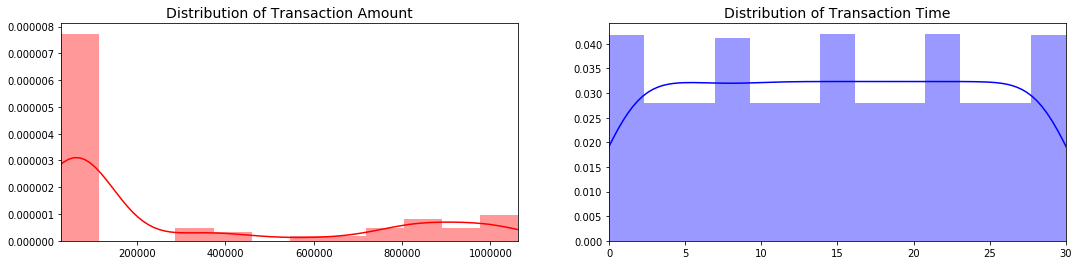

In [23]:
import seaborn as sns
fig, ax = plt.subplots(1, 2, figsize=(18,4))

maxuser_val = test_id['MAX_USER'].values
time_val = test_id['UPDATE_TIME'].values

sns.distplot(maxuser_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(maxuser_val), max(maxuser_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()

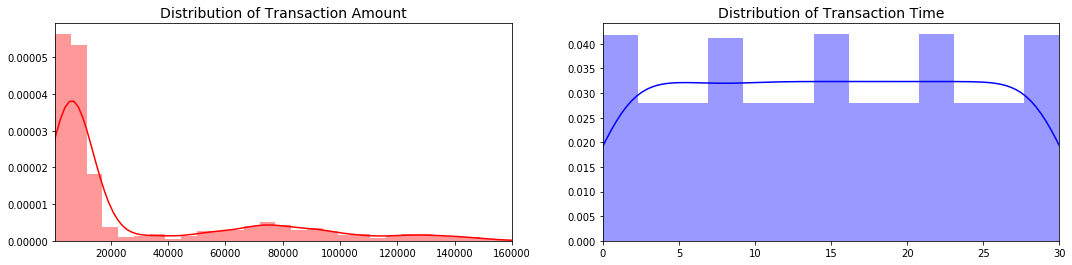

In [24]:
import seaborn as sns
fig, ax = plt.subplots(1, 2, figsize=(18,4))

bandwidth_val = test_id['BANDWIDTH_TOTAL'].values
time_val = test_id['UPDATE_TIME'].values

sns.distplot(bandwidth_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(bandwidth_val), max(bandwidth_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()

# Model: Logistic Regression